**Autor:** Federico Quiroga                 

**Materia:** Procesamiento de Datos
                            
**Topico:** Uso de metricas para la evaluación de un modelo de regresion lienal

**Contenido:** Limpieza, Analisis de Datos, creación y evaluación del modelo de regrsión sobre personas que han sufriendo de un accidente cerebrovascular

# Extraccion de Datos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SQLContext

In [ ]:
# Se crea una SparkSession
spark = SparkSession.builder \
    .appName("SparkEnvironment") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Ruta al archivo CSV en Google Drive
Stroke_File_path = "/content/drive/MyDrive/Colab Notebooks/EXTRA/Prosesamiento datos Datasets/stroke_pyspark.csv"

# Crea un DataFrame de Spark a partir del archivo CSV
df00 = spark.read.csv(Stroke_File_path, header=True, inferSchema=True)

# Muestra las primeras filas del DataFrame
df00.show(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|  

In [ ]:
df00.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

###  Que Datos Contiene el Datafame

`id`: un número único para identificar a cada persona.

`gender`: género de la persona (`Male`, `Female`, `Other`).

`age`: edad en años.

`hypertension`: si tiene presión alta (0 = No, 1 = Sí).

`heart_disease`: si tiene alguna enfermedad del corazón (0 = No, 1 = Sí).

`ever_married`: si alguna vez se ha casado (`Yes` o `No`).

`work_type`: a qué se dedica (`Private`, `Self-employed`, `Govt_job`, `children`, etc.).

`Residence_type`: si vive en zona urbana o rural.

`avg_glucose_level`: nivel promedio de glucosa en sangre.

`bmi`: índice de masa corporal (relación entre peso y estatura).

`smoking_status`: si fuma o ha fumado (`smokes`, `never smoked`, `formerly smoked`, etc.).

`stroke`: si ha tenido un ACV (accidente cerebrovascular) (0 = No, 1 = Sí).


In [ ]:
df00.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



como se puede observar, hay datos numericos son del tipo string

In [ ]:
#Se cambian los datos "age" y "bmi" de string a Int y Double
df01 = df00.withColumn("age", df00.age.cast("int"))
df01 = df00.withColumn("bmi", df00.bmi.cast("double"))
df01.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [ ]:
#Cuantas entradas hay por Genero
df01.groupBy('gender').count().show()


+------+-----+
|gender|count|
+------+-----+
|Female| 2994|
| Other|    1|
|  Male| 2115|
+------+-----+



In [ ]:
# se elimina 'other' de la columna gender al ser solo un dato

# Eliminar filas donde 'gender' es 'Other'
df01 = df01.filter(df01.gender != 'Other')

# Mostrar el recuento de entradas por género después de eliminar 'Other'
df01.groupBy('gender').count().show()


+------+-----+
|gender|count|
+------+-----+
|Female| 2994|
|  Male| 2115|
+------+-----+





# REVISION DE DATOS NULOS Y LIMPIEZA

In [ ]:
df01.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



se encuentra que solo hay datos Nulos en la columba BMI por lo que se remplazara el valor nulo por el su BMI promedio por peso y rango de edades

In [ ]:
# se recolectan los Promedios de el imc

rangos = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90)]



def calcular_promedio_imc(df, gender, rangos):
    promedios = {}
    for start, end in rangos:
        key = f'avg{end}{gender[0]}'

        avg = df.filter((col('gender') == gender) & (col('age') >= start) & (col('age') < end)) \
                .agg(F.mean(col('bmi'))).collect()[0][0]

        promedios[key] = avg

    return promedios

# Calcular los promedios para mujeres y hombres
resultadosF = calcular_promedio_imc(df01, 'Female', rangos)
print(resultadosF)

resultadosM = calcular_promedio_imc(df01, 'Male', rangos)
print(resultadosM)

{'avg10F': 18.687962962962963, 'avg20F': 25.202371541501993, 'avg30F': 28.110054347826086, 'avg40F': 31.114250614250615, 'avg50F': 31.147260273972595, 'avg60F': 31.64794816414686, 'avg70F': 30.777976190476185, 'avg80F': 29.53778501628664, 'avg90F': 28.23577981651375}
{'avg10M': 19.03168724279836, 'avg20M': 24.584051724137947, 'avg30M': 28.228823529411773, 'avg40M': 31.372321428571432, 'avg50M': 31.936329588014974, 'avg60M': 31.889181286549697, 'avg70M': 31.3031496062992, 'avg80M': 29.140291262135918, 'avg90M': 28.34931506849315}


In [ ]:
#remplazar NULL por promedios por su rango de edad

promedios = {**resultadosF, **resultadosM}

def remplazar_nulls(df, promedios, rangos):
    for start, end in rangos:
        for gender in ['Female', 'Male']:
            key = f'avg{end}{gender[0]}'
            avg_bmi = promedios.get(key, None)

            # Asegurarse de que el promedio no sea None
            if avg_bmi is not None:
                # Reemplazar los valores NULL de BMI con el promedio calculado para ese grupo
                df = df.withColumn(
                    'bmi',
                    F.when(
                        (F.col('gender') == gender) &
                        (F.col('age') >= start) & (F.col('age') < end) &
                        F.col('bmi').isNull(), avg_bmi
                    ).otherwise(F.col('bmi'))
                )
    return df


df02 = remplazar_nulls(df01, promedios, rangos)

In [ ]:
#Se visualiza si aun existen datos nulos
df02.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df02.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



# Visualizacion e Analisis de datos

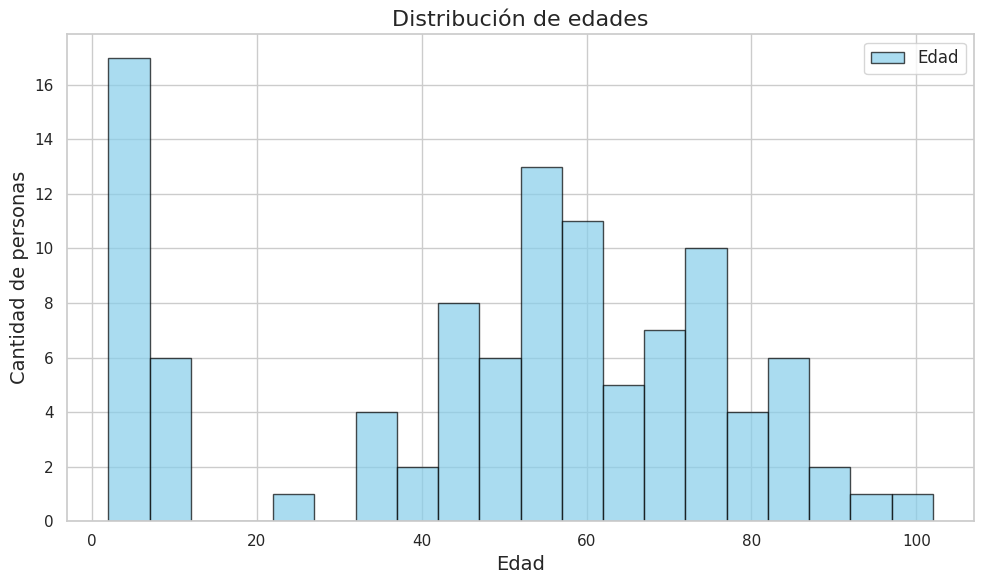

In [ ]:
#Grafico de Distribucion por Edades

sns.set(style="whitegrid")

clases, cantidad = df02.groupby('age').count().select('count').rdd.flatMap(lambda x: x).histogram(20)
plt.figure(figsize=(10, 6))
plt.hist(clases[:-1], bins=clases, weights=cantidad, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de edades', fontsize=16)
plt.xlabel('Edad', fontsize=14)
plt.ylabel('Cantidad de personas', fontsize=14)
plt.legend(['Edad'], loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

Hay una cantida alta de personas muy jovenes entre los datos con edades menores a los 10 años aproximadamente

apartir de los 20 años las edades parecen asemejarse a una distribucion normal

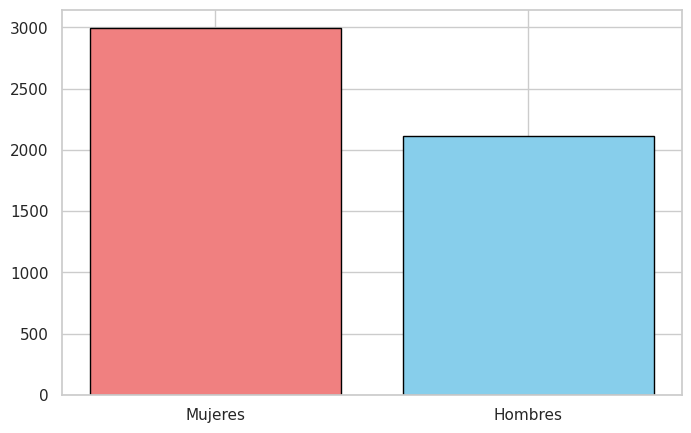

In [ ]:
## Conteo por genero

sns.set(style="whitegrid")
genero = df02.groupby('gender').count().select('count').rdd.flatMap(lambda x: x).collect()

categoria = ['Mujeres', 'Hombres']

plt.figure(figsize=(8, 5))
grafica = plt.bar(categoria, genero, color=['lightcoral', 'skyblue'], edgecolor='black')

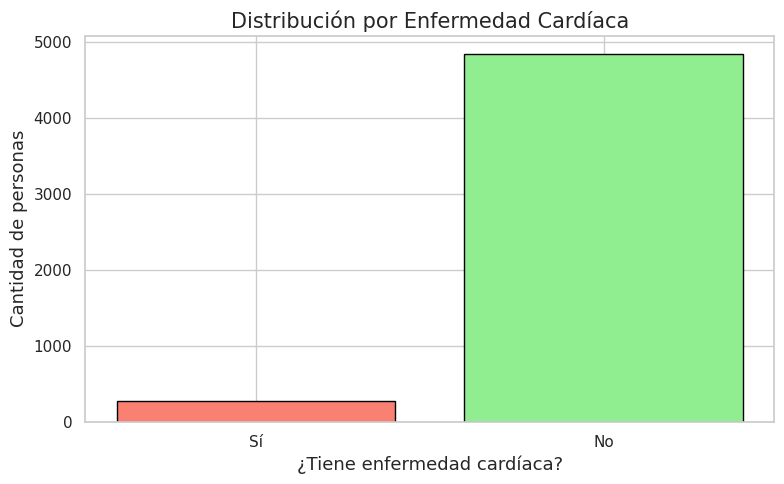

In [ ]:
## Cantidad de personas con enfermedades cardiacas

sns.set(style="whitegrid")

enfCardiaca = df02.groupby('heart_disease').count().select('count').rdd.flatMap(lambda x: x).collect()
categorias = ['Sí', 'No']

plt.figure(figsize=(8, 5))
grafica = plt.bar(categorias, enfCardiaca, color=['salmon', 'lightgreen'], edgecolor='black')

plt.ylabel('Cantidad de personas', fontsize=13)
plt.xlabel('¿Tiene enfermedad cardíaca?', fontsize=13)
plt.title('Distribución por Enfermedad Cardíaca', fontsize=15)

plt.tight_layout()
plt.show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4860|
+------+-----+



<ipython-input-64-a195f64e28cf>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stroke_categories, y=stroke_values, palette='pastel', edgecolor='black')


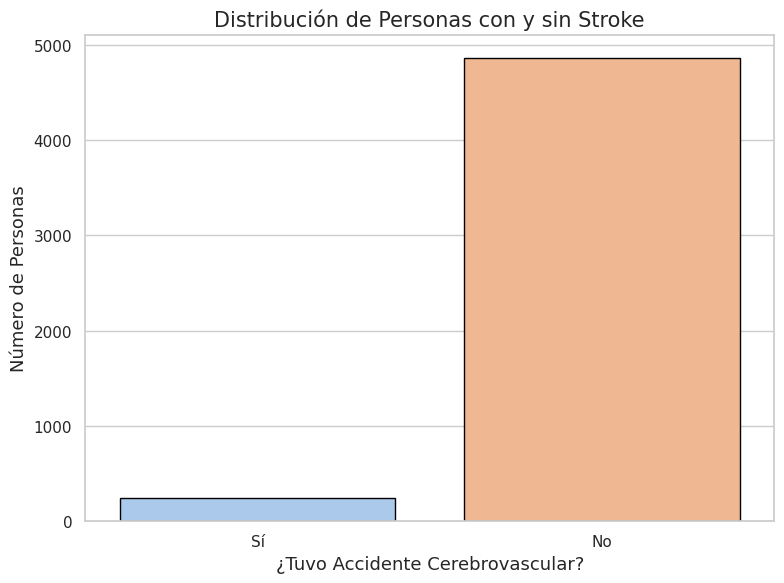

In [ ]:
# grafica de si la persona ha tenido un accidente cardiovascular

sns.set(style="whitegrid")

df02.groupBy('stroke').count().show()
stroke_counts = df02.groupBy('stroke').count().collect()

stroke_categories = ['No', 'Sí'] if stroke_counts[0]['stroke'] == 0 else ['Sí', 'No']
stroke_values = [row['count'] for row in stroke_counts]

plt.figure(figsize=(8, 6))
sns.barplot(x=stroke_categories, y=stroke_values, palette='pastel', edgecolor='black')
plt.xlabel('¿Tuvo Accidente Cerebrovascular?', fontsize=13)
plt.ylabel('Número de Personas', fontsize=13)
plt.title('Distribución de Personas con y sin Stroke', fontsize=15)

plt.tight_layout()
plt.show()



# Creación de un modelo de regresión lineal

Se procede a crear un **modelo de regresión lineal**, el cual se caracteriza por trabajar con una o varias **variables independientes** que se usan para predecir una **variable dependiente**.

En este caso, usaremos las siguientes variables como independientes:

- `gender`  
- `age`  
- `hypertension`  
- `heart_disease`  
- `ever_married`  
- `work_type`  
- `Residence_type`  
- `avg_glucose_level`  
- `bmi`  
- `smoking_status`

Estas se utilizarán para predecir la variable **`stroke`**.

---

### Pasos a seguir:

1. **Conversión de variables categóricas**  
   El modelo solo puede trabajar con variables numéricas, por lo que las variables categóricas se transforman a formato numérico mediante codificación (indexación y one-hot encoding).

2. **Ensamblado de características**  
   Se unifican todas las variables independientes (numéricas y codificadas) en una sola columna mediante un vector de características.

3. **Definición del modelo**  
   Se define el modelo de regresión logística especificando las columnas de entrada (`features`) y salida (`label`).

4. **Creación del pipeline**  
   Se construye un pipeline que integra las transformaciones de datos y el modelo de regresión.

5. **División del dataset**  
   El conjunto de datos se divide en datos de entrenamiento y de prueba.

6. **Entrenamiento del modelo**  
   Se entrena el pipeline con el conjunto de entrenamiento, aplicando todas las transformaciones y el ajuste del modelo.

7. **Predicción y evaluación**  
   Se utiliza el modelo entrenado para predecir la variable dependiente (`stroke`) en el conjunto de prueba, y se muestran los resultados de la predicción.


In [ ]:
df02.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

categoricalCols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numericCols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

# Indexar y codificar las variables categóricas
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep") for col in categoricalCols]
encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec") for col in categoricalCols]

# Ensamblar características
assemblerInputs = numericCols + [col + "_Vec" for col in categoricalCols]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

#  Modelo de regresión logística
Modelolr = LogisticRegression(featuresCol='features', labelCol='stroke', maxIter=10)

#  Pipeline completo
pipeline = Pipeline(stages=indexers + encoders + [assembler, Modelolr])

#  División de los datos (80% entrenamiento, 20% prueba)
train_data, test_data = df02.randomSplit([0.8, 0.2], seed=42)

#  Entrenamiento del modelo
modelo_entrenado = pipeline.fit(train_data)

#  Predicciones
results_ModeloA = modelo_entrenado.transform(test_data)
results_ModeloA.select("stroke", "prediction", "probability").show(10)

+------+----------+--------------------+
|stroke|prediction|         probability|
+------+----------+--------------------+
|     0|       0.0|[0.96936819850976...|
|     0|       0.0|[0.99645781084863...|
|     0|       0.0|[0.99393406028336...|
|     0|       0.0|[0.98727220031075...|
|     0|       0.0|[0.76097305944069...|
|     0|       0.0|[0.98661666885303...|
|     0|       0.0|[0.88425359434421...|
|     1|       0.0|[0.93496693460073...|
|     0|       0.0|[0.99825108913715...|
|     0|       0.0|[0.86254201718851...|
+------+----------+--------------------+
only showing top 10 rows



#Evaluacion de Metricas

Al haber usado un modelo de regresion lineal, se procede a usar metricas para modelos de clasificaion, de esta forma se podra saber que tan bueno es el modelo en predecir la varaible dependiente y en caso de ser necesario re-ajustar o cambiar de modelo.

Se hace un resumen de la cantidad y su proporcion de valores que predijo el modelo y lo mismo con respecto al dataset orginal

Se crea un matriz de confusion para evaluar los dos tipos de error que puede cometer un modelo de machine learning.

Ademas se corrobora usando las metricas de roc, f1 y recall, precision y accuracy

## Resultados del modelo

In [ ]:
# porcentajes de 0 y 1 en columna prediction de resultados del ModeloA
prediction_counts = results_ModeloA.groupBy('prediction').count()
total_predictions = results_ModeloA.count()

prediction_percentages = prediction_counts.withColumn(
    "percentage", col("count") / total_predictions * 100
)

# Muestra el resultado
prediction_percentages.show()


+----------+-----+-------------------+
|prediction|count|         percentage|
+----------+-----+-------------------+
|       0.0|  986|  99.89868287740629|
|       1.0|    1|0.10131712259371835|
+----------+-----+-------------------+



Se analiza que en su totalidad, el modelo predijo a solo un valor como verdadero ( stroke ). Esto nos indica una posible sospecha de que algo esta pasando.

## Dataset Orginial y como compara con el modelo


In [ ]:
stroke_counts = df02.groupBy('stroke').count()
total_rows = df02.count()
stroke_percentage = stroke_counts.withColumn("percentage", col("count") / total_rows * 100)

# Muestra el resultado
stroke_percentage.show()

+------+-----+-----------------+
|stroke|count|       percentage|
+------+-----+-----------------+
|     1|  249|4.873752201996477|
|     0| 4860|95.12624779800353|
+------+-----+-----------------+



Analizando la dataset orignial podemos ver la propocion de l muestra entre perosnas con stroke y no. La proporcion predicho de stroke por el modelo esta vagamente cerca a la de los datos reales. 4.9 vs 0.1.

## Análisis de la matriz de confusión

In [ ]:
# Calcular la matriz de confusión
from pyspark.sql.functions import col

confusion_df = results_ModeloA.groupBy("stroke", "prediction").count().orderBy("stroke", "prediction")
confusion_df.show()

+------+----------+-----+
|stroke|prediction|count|
+------+----------+-----+
|     0|       0.0|  933|
|     1|       0.0|   53|
|     1|       1.0|    1|
+------+----------+-----+




La matriz de confusión muestra que el modelo predice correctamente la mayoría de los casos negativos (`stroke = 0`), pero falla en identificar los casos positivos (`stroke = 1`):

| stroke | prediction | count |
|--------|------------|-------|
|   0    |     0.0    |  933  |
|   1    |     0.0    |   53  |
|   1    |     1.0    |    1  |

Esto indica que el modelo tiene una **muy baja sensibilidad** (mide qué proporción de los verdaderos positivos logró detectar.) ya que solo detectó 1 de los 54 casos reales de stroke.

Este comportamiento se explica por el **fuerte desbalance en el dataset**, donde aproximadamente el **95.1% de los registros corresponden a casos negativos y solo el 4.9% a casos positivos**. En estos escenarios, los modelos tienden a favorecer la clase mayoritaria para minimizar el error global, aunque esto sacrifica la capacidad de detección de eventos importantes.

**Conclusión**: aunque el modelo tiene un alto número de aciertos en la clase negativa, **su utilidad es limitada** si no se toman acciones para abordar el desbalance, ya que **ignora casi por completo los casos que realmente queremos identificar.**


## Evaluación del modelo con AUC-ROC

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Inicializar el evaluador para AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol="stroke", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calcular el AUC-ROC
auc_roc = evaluator.evaluate(results_ModeloA)

print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.823945059743563


El **AUC-ROC (Área Bajo la Curva ROC)** es una métrica que evalúa la capacidad del modelo para distinguir entre las clases positiva y negativa. Su valor oscila entre 0 y 1, donde **1 indica una clasificación perfecta** y **0.5 representa un modelo sin capacidad discriminativa (equivalente al azar)**.

En este caso, el modelo obtuvo un **AUC-ROC de aproximadamente 0.82**, lo cual sugiere que, a pesar del fuerte desbalance en las clases y la baja sensibilidad observada en la matriz de confusión, **el modelo tiene una buena capacidad general para distinguir entre personas con y sin accidente cerebrovascular**.

Esto indica que el modelo sí está captando patrones útiles, aunque su rendimiento puede mejorar.


## Evaluación con métricas clásicas de clasificación

In [ ]:
evaluator_acc = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")

# Imprimir métricas
print("Accuracy: ", evaluator_acc.evaluate(results_ModeloA))
print("Precision: ", evaluator_precision.evaluate(results_ModeloA))
print("Recall: ", evaluator_recall.evaluate(results_ModeloA))
print("F1 Score: ", evaluator_f1.evaluate(results_ModeloA))


Accuracy:  0.9463019250253293
Precision:  0.9491883327065235
Recall:  0.9463019250253293
F1 Score:  0.9211707476938703


A pesar del fuerte desbalance de clases (4.9% positivos), estas métricas muestran valores altos. Sin embargo, dado el resultado de la matriz de confusión (donde solo se detectó 1 caso real de `stroke`), esto indica que estas métricas pueden ser engañosas, ya que están influenciadas por la alta proporción de casos negativos, lo que reduce su confiabilidad para evaluar el desempeño sobre la clase minoritaria.

**Conclusión**: el modelo obtiene buenos resultados en métricas agregadas, pero aún tiene **limitaciones importantes para identificar correctamente los casos positivos de `stroke`**, lo cual es crítico en aplicaciones de salud.

## Conclusión


El desarrollo de un proyecto de ciencia de datos implica una serie de pasos que deben ejecutarse con cuidado para obtener resultados valiosos. Uno de estos pasos clave es la evaluación de los modelos de predicción que se crean y entrenan durante el proceso. Para ello, el uso de métricas es fundamental, ya que permiten medir el desempeño del modelo y guiar su mejora, especialmente en contextos donde la precisión es crucial. Por esta razón, comprender qué miden estas métricas, cómo se interpretan y qué factores considerar al aplicarlas, resulta aún más importante. En este taller se utilizaron métricas específicas para modelos de clasificación, dada la naturaleza del conjunto de datos, y se logró interpretarlas de forma que aporten valor para el desarrollo y mejora de futuros modelos.